<a href="https://colab.research.google.com/github/fatememosleh222/Big-Data-Machine-Learning/blob/Master/Coursework_CN7050_Domain_Name_MKM_05_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Coursework_CN7050 - Domain Name Value Prediction- 2023-24**


# **Importing required libraries**

In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import math
from nltk import ngrams
import collections
import urllib
import requests
import keras
import category_encoders as ce

# from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,RandomizedSearchCV,KFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import LabelBinarizer
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, load_model

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


# **Loading the data**

In [ ]:
data=pd.read_csv('/content/DomainMerged_5_underSampling.csv')

# **Exploring the Data**

In [ ]:
dist = data.category.value_counts().to_frame().reset_index()
dist['% distribution'] = data.category.value_counts().values/data.shape[0] * 100
dist.columns = ['categories', 'count', '% distribution']

In [ ]:
dist

,categories,count,% distribution
0,1,300000,43.902525
1,2,229567,33.595236
2,3,107932,15.794958
3,4,35454,5.188400
4,5,10379,1.518881


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683332 entries, 0 to 683331
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Domain    683332 non-null  object
 1   category  683332 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.4+ MB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
category,683332.0,1.868259,0.961174,1.0,1.0,2.0,2.0,5.0


In [ ]:
data['category'].value_counts()

1    300000
2    229567
3    107932
4     35454
5     10379
Name: category, dtype: int64

#todo
 visualiztion
 We need to express a few diagram to explor the data, bar chart, pie

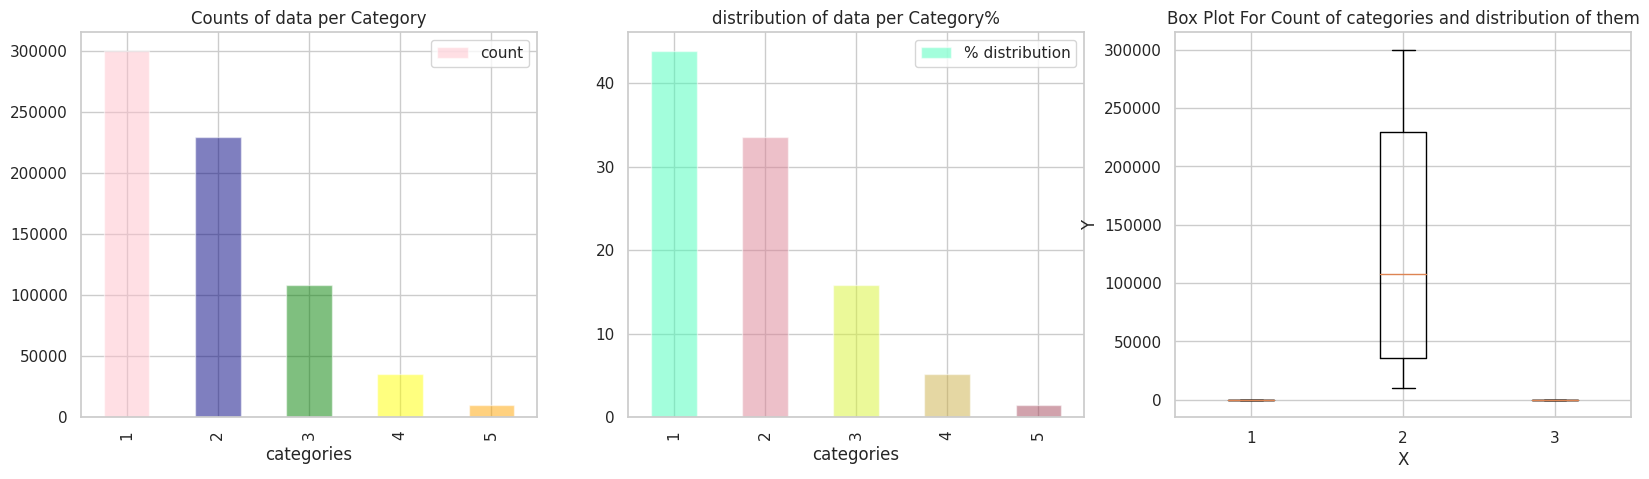

In [ ]:
fig, axs = plt.subplots(1, 3,figsize=(20,5))
colors = ['pink', 'navy', 'green', 'yellow', 'orange']
randomcolors = np.random.rand(5, 3)
# Plot a bar chart using the dataframe
dist.plot(kind="bar", x="categories", y="count",alpha=0.5, color=colors, title="Counts of data per Category", ax=axs[0])

dist.plot(kind="bar", x="categories", y="% distribution",alpha=0.5,color=randomcolors, title="distribution of data per Category%", ax=axs[1])

# Create a box plot
axs[2].boxplot(dist)
plt.title('Box Plot For Count of categories and distribution of them')
plt.xlabel('X')
plt.ylabel('Y')


# Show the chart
plt.show()

# **Feature Extraction and Feature Engineering**

In [ ]:
data['d_name']=data['Domain'].apply(lambda x: x.split('.')[0].lower())
data['d_len']=data['d_name'].apply(lambda x: len(x))
data['sub_d_len']=data['d_name'].apply(lambda x: len(x.split('.'))-1)
data['tld']=data['Domain'].apply(lambda x: x.split('.')[-1])
data['haveing_digits'] = data['d_name'].apply(lambda x: 0 if len(re.findall('\d', x)) == 0 else 1)
data['number_of_digits'] = data['d_name'].apply(lambda x: len(re.findall('[0-9]',x)))
data['number_of_char'] = data['d_len']-data['number_of_digits']

data['rate_digit_to_all'] =(data['number_of_digits']/data['d_len'])*100
data['rate_char_to_all'] =(data['number_of_char']/data['d_len'])*100
data['rate_digit_to_char'] =data.apply(lambda x:x['number_of_digits']/(1 if x['number_of_char']==0 else x['number_of_char']), axis=1)*100

data['having_&'] =data['d_name'].apply(lambda x: 0 if len(re.findall('&', x)) == 0 else 1)
data.head(2)

,Domain,category,d_name,d_len,sub_d_len,tld,haveing_digits,number_of_digits,number_of_char,rate_digit_to_all,rate_char_to_all,rate_digit_to_char,having_&
0,grapevineplumbing.com,1,grapevineplumbing,17,0,com,0,0,17,0.0,100.0,0.0,0
1,willswebsitedemos.com,1,willswebsitedemos,17,0,com,0,0,17,0.0,100.0,0.0,0


In [ ]:
data.loc[:, (data == 0).all()].columns

Index(['sub_d_len', 'having_&'], dtype='object')

In [ ]:
data=data.loc[:, (data != 0).any(axis=0)]

In [ ]:
def entropy_estimation (input):
  probability = (np.unique (list (input), return_counts=True) [1]) / len (input)
  return ( - np.sum (probability * np.log2 (probability)))

data['entropy'] = np.vectorize (entropy_estimation) (np.array (data['d_name']))

data.head(2)

,Domain,category,d_name,d_len,tld,haveing_digits,number_of_digits,number_of_char,rate_digit_to_all,rate_char_to_all,rate_digit_to_char,entropy
0,grapevineplumbing.com,1,grapevineplumbing,17,com,0,0,17,0.0,100.0,0.0,3.499228
1,willswebsitedemos.com,1,willswebsitedemos,17,com,0,0,17,0.0,100.0,0.0,3.175123


# **todo**
visualize the distribution of these new features, for each category plot diferent features and correlation between tld and 3 featuers separately with diagrams, (entropy)

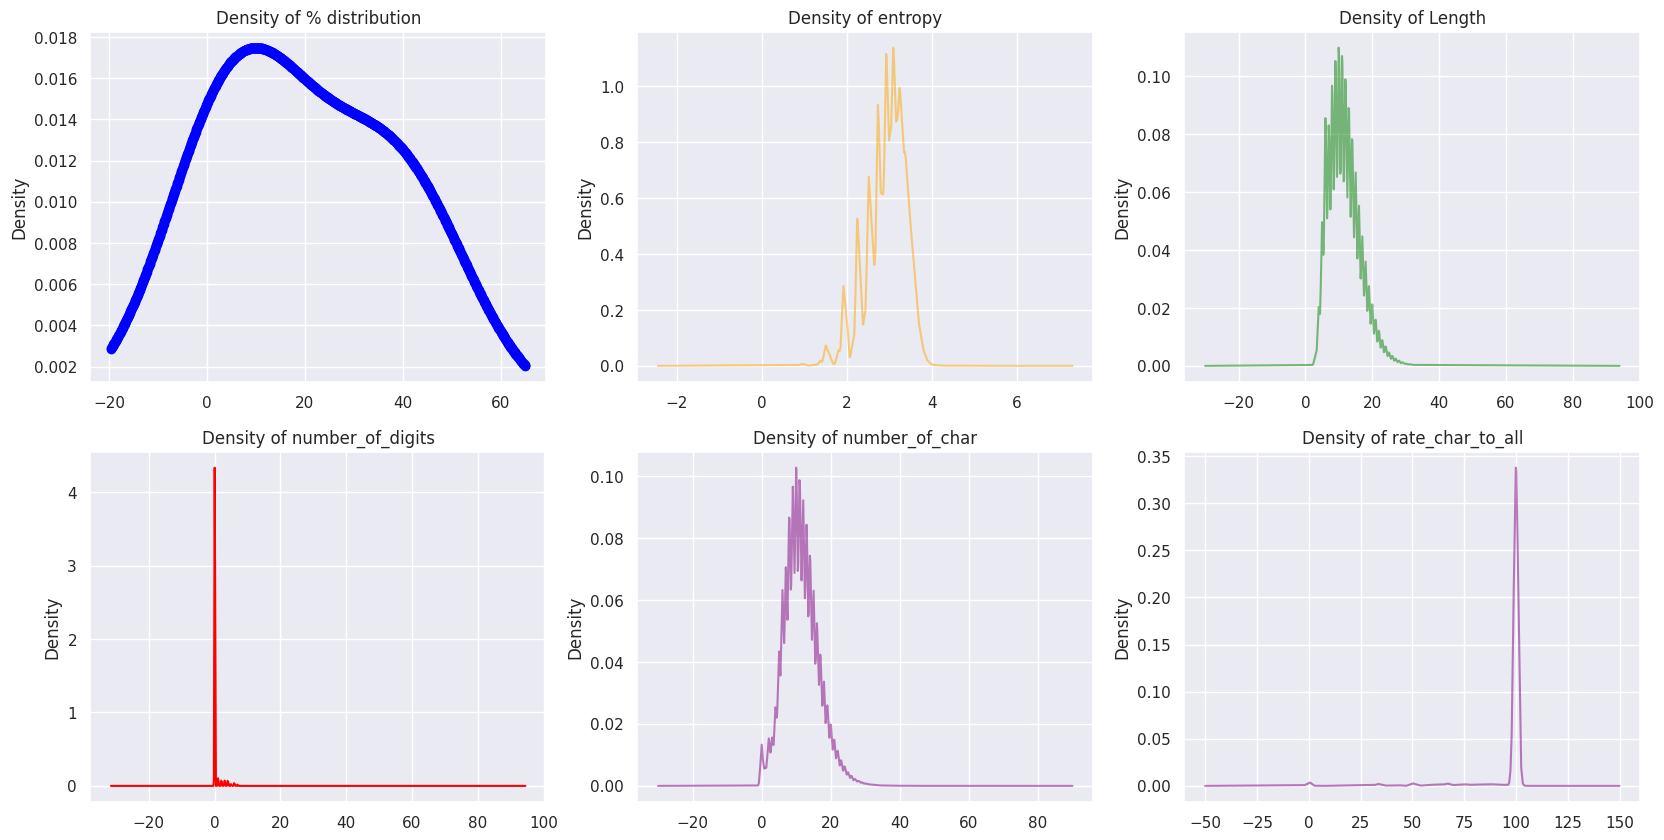

In [ ]:
import seaborn as sns
import matplotlib.style as mplstyle


mplstyle.use('fast')


fig, axs = plt.subplots(2, 3,figsize=(20,10))

# Set the style and palette
sns.set_style('darkgrid')
sns.set_palette('muted')

dist['% distribution'].plot(kind='density', color='blue',marker='o',ax=axs[0,0])
axs[0,0].set_title('Density of % distribution')

data['entropy'].plot(kind='density', color='orange',alpha=0.5,ax=axs[0,1])
axs[0,1].set_title('Density of entropy')

data['d_len'].plot(kind='density', color='green',alpha=0.5,ax=axs[0,2])
axs[0,2].set_title('Density of Length')

data['number_of_digits'].plot(kind='density', color='red',ax=axs[1,0])
axs[1,0].set_title('Density of number_of_digits')

data['number_of_char'].plot(kind='density', color='purple',alpha=0.5,ax=axs[1,1])
axs[1,1].set_title('Density of number_of_char')


data['rate_char_to_all'].plot(kind='density', color='yellow',alpha=0.5,ax=axs[1,2])
axs[1,2].set_title('Density of rate_char_to_all')


# Plot a density plot of d_name
# axs[1,2].hist(data['d_name'], density=True, bins=5)
# axs[1,2].set_title('Density plot of d_name')
# plt.xlabel('d_name')
# plt.ylabel('Density')

# Plot a density plot of data['number_of_char']
#sns.kdeplot(data=data, x='number_of_char', color='purple', shade=True, bw_adjust=0.5)

plt.show()




The correlation coefficient is 0.78 between entropy and d_len
The correlation coefficient is -0.24 between entropy and number_of_digits


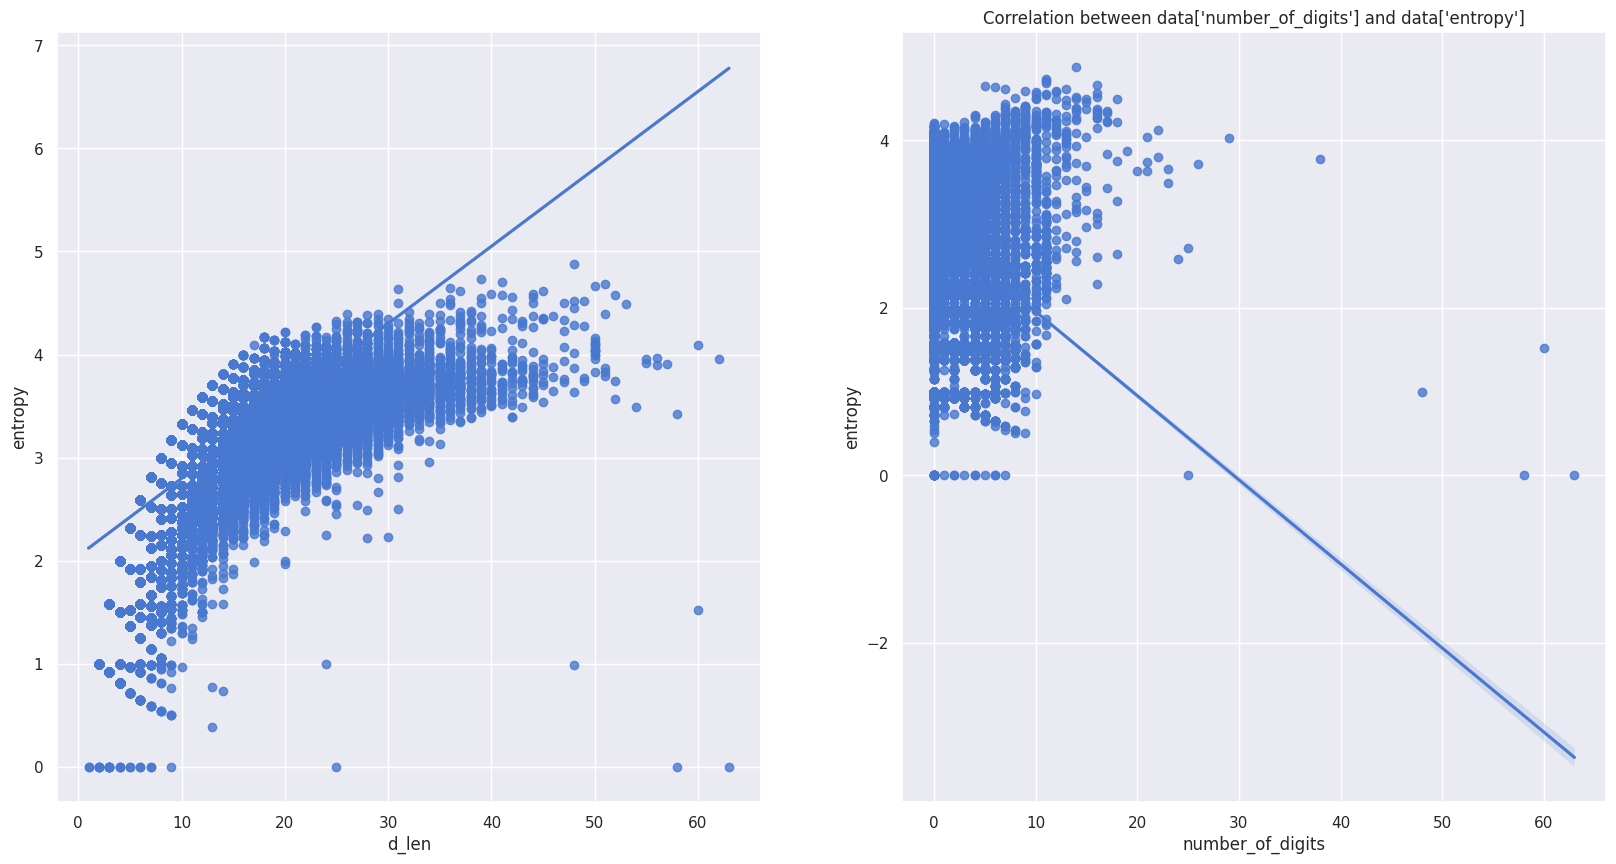

In [ ]:

# Calculate the correlation coefficient between data['tld'] and data['entropy']
fig, axs = plt.subplots(1, 2,figsize=(20,10))

corr = np.corrcoef(data['d_len'], data['entropy'])[0, 1]
print(f'The correlation coefficient is {corr:.2f} between entropy and d_len')

# Plot a scatter plot with a regression line
sns.regplot(x='d_len', y='entropy', data=data,ax=axs[0])
plt.title('Correlation between data[\'d_len\'] and data[\'entropy\']')
plt.xlabel('d_len')
plt.ylabel('entropy')


# Calculate the correlation coefficient between data['tld'] and data['entropy']
corr = np.corrcoef(data['number_of_digits'], data['entropy'])[0, 1]
print(f'The correlation coefficient is {corr:.2f} between entropy and number_of_digits')

# Plot a scatter plot with a regression line
sns.regplot(x='number_of_digits', y='entropy', data=data,ax=axs[1])
plt.title('Correlation between data[\'number_of_digits\'] and data[\'entropy\']')
plt.xlabel('number_of_digits')
plt.ylabel('entropy')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(data['category'].unique(),data['category'].value_counts())
# need to show with different color

In [ ]:
data['category'].value_counts()

Transform tld to dummy variables

In [ ]:
cat_values = pd.get_dummies(data.tld)
data=pd.concat([data, cat_values], axis=1)
data.head()

,Domain,category,d_name,d_len,tld,haveing_digits,number_of_digits,number_of_char,rate_digit_to_all,rate_char_to_all,...,ph,pk,pl,ro,sg,tw,ua,uy,ve,vn
0,grapevineplumbing.com,1,grapevineplumbing,17,com,0,0,17,0.000000,100.000000,...,0,0,0,0,0,0,0,0,0,0
1,willswebsitedemos.com,1,willswebsitedemos,17,com,0,0,17,0.000000,100.000000,...,0,0,0,0,0,0,0,0,0,0
2,wolfriverpress.com,1,wolfriverpress,14,com,0,0,14,0.000000,100.000000,...,0,0,0,0,0,0,0,0,0,0
3,fashionistatoolkit.com,1,fashionistatoolkit,18,com,0,0,18,0.000000,100.000000,...,0,0,0,0,0,0,0,0,0,0
4,407visa.com,1,407visa,7,com,1,3,4,42.857143,57.142857,...,0,0,0,0,0,0,0,0,0,0


Generate trigram features

In [ ]:
def n_gram_extraction(str, n):
  result=[''.join(n) for n in zip(*[str[a:] for a in range(0,n)])]
  return result

data['trigram']=data['d_name'].apply(lambda x: n_gram_extraction(x,3))

In [ ]:
data['counter_of_trigram']=data['trigram'].apply(lambda x:  collections.Counter(x))

In [ ]:
data["number_of_high_occurance_trigram"]=data['counter_of_trigram'].apply(lambda x:  0 if len(x.values())==0 else max(x.values()) )

In [ ]:
def number_of_high_occurance_char(input, max_value):
  return len([(key,value) for key,value in input.items() if value == max_value])

data["num_each_high_occurance_trigram"]=data.apply(lambda x: number_of_high_occurance_char(x["counter_of_trigram"],x["number_of_high_occurance_trigram"]), axis=1)

In [ ]:
data=data.loc[:, (data != 0).any(axis=0)]

Vectorize and generating the bag of words for ngram features

In [ ]:
temp=data['trigram'].apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(temp)
columns = vectorizer.get_feature_names_out()

df_temp =  pd.DataFrame(X.toarray(), columns=columns)
data=pd.concat([data , df_temp], axis=1)

Transform the target value as a categorical value to binary values.

**Note:** This will be used for future contribution because in this project running the deep learning algorithms needs more resources.)

In [ ]:
y_cat = LabelBinarizer().fit_transform(data.category)
y_cat_1=keras.utils.to_categorical(y_cat,num_classes=5)
t=pd.DataFrame(y_cat, columns =['lbl1', 'lbl2','lbl3','lbl4','lbl5'])
data=pd.concat([data , t], axis=1)

###Random forest, XGBoost, SVC

In [ ]:
data_1 = data[data['category']==1].sample(frac=0.02)
data_2 = data[data['category']==2].sample(frac=0.02)
data_3 = data[data['category']==3].sample(frac=0.02)
data_4 = data[data['category']==4].sample(frac=0.02)
data_5 = data[data['category']==5].sample(frac=0.02)

data_sample = pd.concat([data_1,data_2,data_3,data_4,data_5])

In [ ]:
#data_sample.columns.get_loc("num_each_high_occurance_trigram")

df = data_sample.iloc[:, 0:49]
df.columns

Index(['Domain', 'category', 'd_name', 'd_len', 'tld', 'haveing_digits',
       'number_of_digits', 'number_of_char', 'rate_digit_to_all',
       'rate_char_to_all', 'rate_digit_to_char', 'ag', 'ar', 'au', 'bo', 'br',
       'cn', 'co', 'com', 'es', 'gr', 'gt', 'mx', 'my', 'ng', 'pe', 'ph', 'pk',
       'pl', 'ro', 'sg', 'tw', 'ua', 'uy', 've', 'vn', 'entropy', 'unigram',
       'bigram', 'trigram', 'counter_of_unigram', 'counter_of_bigram',
       'counter_of_trigram', 'number_of_high_occurance_unigram',
       'number_of_high_occurance_bigram', 'number_of_high_occurance_trigram',
       'num_each_high_occurance_unigram', 'num_each_high_occurance_bigram',
       'num_each_high_occurance_trigram'],
      dtype='object')

In [ ]:
#please check irrelevant features
X=df.drop(columns=['Domain','category','d_name','tld','unigram','bigram','trigram','counter_of_unigram','counter_of_bigram',
                      'counter_of_trigram'], axis=1)
y=df['category']

In [ ]:
print('Total number of extracted features: ',len(X.columns))

Total number of extracted features:  39


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled_df=pd.DataFrame(X_scaled, columns =X.columns)

In [ ]:
X_scaled_df.head()

,d_len,haveing_digits,number_of_digits,number_of_char,rate_digit_to_all,rate_char_to_all,rate_digit_to_char,ag,ar,au,...,uy,ve,vn,entropy,number_of_high_occurance_unigram,number_of_high_occurance_bigram,number_of_high_occurance_trigram,num_each_high_occurance_unigram,num_each_high_occurance_bigram,num_each_high_occurance_trigram
0,-1.006377,3.116218,6.064192,-2.260833,6.135410,-6.135410,8.674541,0.0,-0.008554,-0.041058,...,0.0,0.0,0.0,-1.753757,0.649670,1.721549,-0.180185,-0.666523,-1.383365,-0.913038
1,0.461516,-0.320902,-0.270901,0.491529,-0.263398,0.263398,-0.185419,0.0,-0.008554,-0.041058,...,0.0,0.0,0.0,0.226368,0.649670,-0.514567,-0.180185,-0.666523,1.023746,0.553836
2,-1.216076,3.116218,3.349152,-1.867638,4.002474,-4.002474,2.345998,0.0,-0.008554,-0.041058,...,0.0,0.0,0.0,-0.760770,-1.512522,-0.514567,-0.180185,1.762384,-0.580995,-1.122591
3,-1.006377,3.116218,2.444138,-1.474444,2.478948,-2.478948,0.763862,0.0,-0.008554,-0.041058,...,0.0,0.0,0.0,-0.898396,-0.431426,-0.514567,-0.180185,-0.666523,-0.380402,-0.913038
4,-0.586979,-0.320902,-0.270901,-0.491457,-0.263398,0.263398,-0.185419,0.0,-0.008554,-0.041058,...,0.0,0.0,0.0,0.027617,-0.431426,-0.514567,-0.180185,-0.666523,0.020783,-0.493931


In [ ]:
X_scaled_df.shape

(13667, 39)

In [ ]:
len(y)

13667

# **Classification Algorithms**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state = 0)

In [ ]:
X_train.shape, X_test.shape

((9566, 39), (4101, 39))

## **SVM**

In [ ]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

[[3051 1403    0    0    0]
 [1756 1713    1    0    0]
 [ 683  928    0    0    0]
 [ 191  367    0    0    0]
 [  33  122    0    0    3]] 0.4650278021656424 0.4062320062857035 0.37533099358555916 0.4650278021656424
              precision    recall  f1-score   support

           1       0.69      0.53      0.60      5714
           2       0.49      0.38      0.43      4533
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.02      1.00      0.04         3

    accuracy                           0.47     10251
   macro avg       0.24      0.38      0.21     10251
weighted avg       0.60      0.47      0.52     10251



Showing precisioin,reacall and f1-score

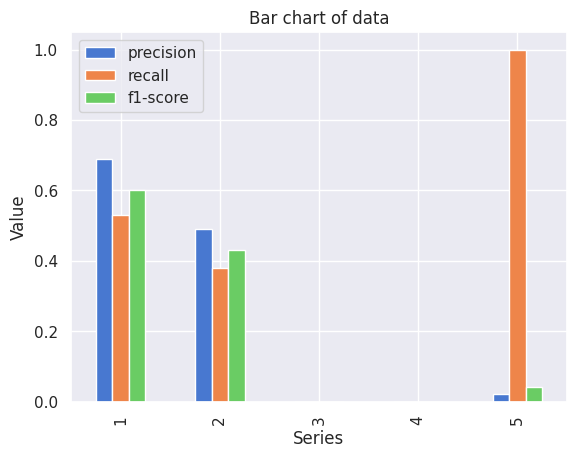

In [ ]:
# Create a dataframe from the data
data = {"precision": [0.69, 0.49, 0.00, 0.00, 0.02],
        "recall": [0.53, 0.38, 0.00, 0.00, 1.00],
        "f1-score": [0.60, 0.43, 0.00, 0.00, 0.04],
       # "support": [5714, 4533, 1, 0, 3]
        }
df = pd.DataFrame(data, index=[1, 2, 3, 4, 5])

# Plot the bar chart with different series
df.plot.bar()
plt.xlabel("Series")
plt.ylabel("Value")
plt.title("Bar chart of data")
plt.show()

**calculating feature importance**

In [ ]:
# Calculate the permutation feature importance
perm_importance = permutation_importance(svc, X_test, y_test, n_repeats=10, random_state=0)

# Get the mean and standard deviation of the importance scores
importances = perm_importance.importances_mean
std = perm_importance.importances_std

# Plot the feature importances as a bar chart with error bars
plt.bar(X.columns, importances, yerr=std)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Permutation Feature Importance for SVM with rbf kernel")
plt.show()

In [ ]:
# Calculate and plot the ROC curve and the AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
print("AUC score:", auc)
plot_roc_curve(svc, X_test, y_test)
plt.title("ROC curve for SVM with linear kernel")
plt.show()


# Plot the confusion matrix as a heatmap
plot_confusion_matrix(svc, X_test, y_test, cmap='Blues')
plt.title("Confusion matrix for SVM with linear kernel")
plt.show()




Hyperparameter tuning using grid search and cross validation¶

In [ ]:
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10]},
                    {'kernel': ['linear'], 'C': [1, 10]}]

In [ ]:
model = SVC()
grid_search = GridSearchCV(model,
                           param_grid=param_grid, cv=5, verbose=10,scoring="accuracy")
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print("Using hyperparameters --> \n", grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=1, gamma=0.001, kernel=rbf................................
[CV 1/5; 1/6] END .C=1, gamma=0.001, kernel=rbf;, score=0.464 total time=  41.9s
[CV 2/5; 1/6] START C=1, gamma=0.001, kernel=rbf................................
[CV 2/5; 1/6] END .C=1, gamma=0.001, kernel=rbf;, score=0.458 total time=  41.0s
[CV 3/5; 1/6] START C=1, gamma=0.001, kernel=rbf................................
[CV 3/5; 1/6] END .C=1, gamma=0.001, kernel=rbf;, score=0.448 total time=  43.0s
[CV 4/5; 1/6] START C=1, gamma=0.001, kernel=rbf................................
[CV 4/5; 1/6] END .C=1, gamma=0.001, kernel=rbf;, score=0.457 total time=  40.4s
[CV 5/5; 1/6] START C=1, gamma=0.001, kernel=rbf................................
[CV 5/5; 1/6] END .C=1, gamma=0.001, kernel=rbf;, score=0.451 total time=  41.1s
[CV 1/5; 2/6] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 1/5; 2/6] END C=1, gamma=0.0001, kernel=rbf;,

Compare the result for different parameter

In [ ]:
# Training the model with best parameteres

model = SVC(bootstrap= True,criterion= 'gini', max_depth=6,
                               max_features= 'sqrt', max_leaf_nodes= 6,
                               min_samples_leaf= 2, n_estimators=50)

model.fit(X_train, y_train)

y_pred=model.predict(X_test)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

# print('accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

#Visulize the result

Diagram for cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value

In [ ]:
feature_importance = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending = False)

features_=feature_importance.index
importance_vals_=feature_importance.values

temp=({'feature': features_, 'importance_val':importance_vals_})
df_ = pd.DataFrame(temp)
df_=df_[df_.importance_val>0.0001]
features_new=list(df_.feature)
X_train_new=X_train[features_new]
X_test_new=X_test[features_new]

#Visulize the imporatnt feature colorful

Diagram for feature importance

In [ ]:
# Training the model with best parameteres and important feature

model = SVC(bootstrap= True,criterion= 'gini', max_depth=6,
                               max_features= 'sqrt', max_leaf_nodes= 6,
                               min_samples_leaf= 2, n_estimators=50)

model.fit(X_train_new, y_train)

y_pred=model.predict(X_test_new)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

# print('accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

## **Random Forest**

In [ ]:
### Implementation with defult paremeter

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred=model.predict(X_test)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

[[1016  690   47    7    0]
 [ 592  785   35    2    1]
 [ 254  396   15    4    1]
 [  71  129    4    2    1]
 [  17   26    2    0    4]] 0.4442818824676908 0.40144152958093277 0.3946447359666248 0.4442818824676908
              precision    recall  f1-score   support

           1       0.58      0.52      0.55      1950
           2       0.55      0.39      0.46      2026
           3       0.02      0.15      0.04       103
           4       0.01      0.13      0.02        15
           5       0.08      0.57      0.14         7

    accuracy                           0.44      4101
   macro avg       0.25      0.35      0.24      4101
weighted avg       0.55      0.44      0.49      4101



In [ ]:
#https://python.plainenglish.io/roc-auc-in-machine-learning-d70d4308f636

In [ ]:
# y_pred_prob = model_rf.predict_proba(X_test)[::, 1]

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

In [ ]:
# plt.figure(figsize=(12,6))
# plt.plot(fpr,tpr,label="Random Forest Classifier")
# # plt.plot(fpr1,tpr1,label="Random Forest Classifier")
# # plt.plot(fpr2,tpr2,label="Gaussian Naive Bayes")

# plt.legend(loc=4)
# plt.grid(color='b', ls = '-.', lw = 0.25)
# plt.show()

In [ ]:
# y_pred_proba = model.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# plt.plot([0,1],[0,1],'k--')
# plt.plot(fpr,tpr, label='ANN')
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# plt.title('ROC curve')
# plt.show()

In [ ]:
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# roc_auc

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 6],
    'max_leaf_nodes': [3, 6],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [2],
    "bootstrap": [True, False],
}

In [ ]:
model = RandomForestClassifier(random_state = 42)
grid_search = GridSearchCV(model,
                           param_grid=param_grid, cv=5, verbose=10,scoring="accuracy")
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print("Using hyperparameters --> \n", grid_search.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=2, n_estimators=50
[CV 1/5; 1/64] END bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=2, n_estimators=50;, score=0.441 total time=   0.7s
[CV 2/5; 1/64] START bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=2, n_estimators=50
[CV 2/5; 1/64] END bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=2, n_estimators=50;, score=0.441 total time=   1.9s
[CV 3/5; 1/64] START bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=2, n_estimators=50
[CV 3/5; 1/64] END bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, max_leaf_nodes=3, min_samples_leaf=2, n_estimators=50;, score=0.441 total time=   0.5s
[CV 4/5; 1/

AttributeError: ignored

In [ ]:
# Training the model with best parameteres

model = RandomForestClassifier(bootstrap= True,criterion= 'gini', max_depth=6,
                               max_features= 'sqrt', max_leaf_nodes= 6,
                               min_samples_leaf= 2, n_estimators=50)

model.fit(X_train, y_train)

y_pred=model.predict(X_test)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

# print('accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

#Visulize the result

[[3453 1001    0    0    0]
 [2226 1244    0    0    0]
 [ 842  769    0    0    0]
 [ 251  307    0    0    0]
 [  56  102    0    0    0]] 0.45819920007804116 0.3881464489688331 0.3427491141559367 0.45819920007804116
              precision    recall  f1-score   support

           1       0.78      0.51      0.61      6828
           2       0.36      0.36      0.36      3423
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.46     10251
   macro avg       0.23      0.17      0.19     10251
weighted avg       0.64      0.46      0.53     10251



In [ ]:
feature_importance = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending = False)

features_=feature_importance.index
importance_vals_=feature_importance.values

temp=({'feature': features_, 'importance_val':importance_vals_})
df_ = pd.DataFrame(temp)
df_=df_[df_.importance_val>0.0001]
features_new=list(df_.feature)
X_train_new=X_train[features_new]
X_test_new=X_test[features_new]

#Visulize the imporatnt feature colorful

In [ ]:
# Training the model with best parameteres and important feature

model = RandomForestClassifier(bootstrap= True,criterion= 'gini', max_depth=6,
                               max_features= 'sqrt', max_leaf_nodes= 6,
                               min_samples_leaf= 2, n_estimators=50)

model.fit(X_train_new, y_train)

y_pred=model.predict(X_test_new)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

# print('accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

Calculating Feature Importance

In [ ]:
importances = model.feature_importances_

# Plot the feature importances as a bar chart
plt.bar(X.columns, importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance for Random Forest")
plt.show()

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Load the data
data = pd.read_csv("data.csv")

# Split the data into input and output
X = data.drop("target", axis=1)
y = data["target"]

# Fit a random forest model
rf = RandomForestClassifier(n_estimators=10, random_state=0)
rf.fit(X, y)

# Plot the first three trees
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_tree(rf.estimators_[i], feature_names=X.columns, filled=True, max_depth=2)
    plt.title(f"Tree {i+1}")
plt.show()


## **XGBOOST**

In [ ]:
y=data_sample['category']-1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state = 0)

In [ ]:
# https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance

from xgboost import XGBClassifier

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred=model.predict(X_test)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

[[1154  590   16    0    0]
 [ 721  670   23    1    0]
 [ 292  372    6    0    0]
 [  62  142    2    0    1]
 [  17   32    0    0    0]] 0.44623262618873444 0.39353340797638997 0.36936567147224025 0.44623262618873444
              precision    recall  f1-score   support

           0       0.66      0.51      0.58      2246
           1       0.47      0.37      0.42      1806
           2       0.01      0.13      0.02        47
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.45      4101
   macro avg       0.23      0.20      0.20      4101
weighted avg       0.57      0.45      0.50      4101



In [ ]:
model = XGBClassifier()
grid_search = GridSearchCV(model,
                           param_grid=param_grid, cv=5, verbose=10,scoring="accuracy")
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print("Using hyperparameters --> \n", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START alpha=10, learning_rate=0.1, max_depth=3, n_estimators=50, objective=binary:logistic
[CV 1/5; 1/16] END alpha=10, learning_rate=0.1, max_depth=3, n_estimators=50, objective=binary:logistic;, score=0.475 total time=   1.4s
[CV 2/5; 1/16] START alpha=10, learning_rate=0.1, max_depth=3, n_estimators=50, objective=binary:logistic
[CV 2/5; 1/16] END alpha=10, learning_rate=0.1, max_depth=3, n_estimators=50, objective=binary:logistic;, score=0.477 total time=   0.8s
[CV 3/5; 1/16] START alpha=10, learning_rate=0.1, max_depth=3, n_estimators=50, objective=binary:logistic
[CV 3/5; 1/16] END alpha=10, learning_rate=0.1, max_depth=3, n_estimators=50, objective=binary:logistic;, score=0.472 total time=   0.5s
[CV 4/5; 1/16] START alpha=10, learning_rate=0.1, max_depth=3, n_estimators=50, objective=binary:logistic
[CV 4/5; 1/16] END alpha=10, learning_rate=0.1, max_depth=3, n_estimators=50, objective=binary:logistic;

In [ ]:
# Training the model with best parameteres

model = XGBClassifier(alpha= 10, max_depth=6, learning_rate= 0.1,
                               objective= 'binary:logistic', n_estimators=100)

model.fit(X_train, y_train)

y_pred=model.predict(X_test)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

# print('accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

#Visulize the result

[[1248  512    0    0    0]
 [ 806  609    0    0    0]
 [ 313  357    0    0    0]
 [  70  137    0    0    0]
 [  17   32    0    0    0]] 0.4528163862472568 0.3914473478018472 0.3458366400736649 0.4528163862472568
              precision    recall  f1-score   support

           0       0.71      0.51      0.59      2454
           1       0.43      0.37      0.40      1647
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.45      4101
   macro avg       0.23      0.18      0.20      4101
weighted avg       0.60      0.45      0.51      4101



In [ ]:
feature_importance = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending = False)

features_=feature_importance.index
importance_vals_=feature_importance.values

temp=({'feature': features_, 'importance_val':importance_vals_})
df_ = pd.DataFrame(temp)
df_=df_[df_.importance_val>0.0001]
features_new=list(df_.feature)
X_train_new=X_train[features_new]
X_test_new=X_test[features_new]

#Visulize the imporatnt feature colorful

In [ ]:
# Training the model with best parameteres and important feature

model = XGBClassifier(alpha= 10, max_depth=6, learning_rate= 0.1,
                               objective= 'binary:logistic', n_estimators=100)

model.fit(X_train_new, y_train)

y_pred=model.predict(X_test_new)

cm_value= confusion_matrix(y_test, y_pred)
accuracy_score_value= accuracy_score(y_test, y_pred)
f1_score_value=f1_score(y_test, y_pred, pos_label=1, average='weighted')
precision_score_value=precision_score(y_test, y_pred, pos_label=1, average='weighted')
recall_score__value=recall_score(y_test, y_pred, pos_label=1, average='weighted')

# print('accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(cm_value,
      accuracy_score_value,
      f1_score_value,
      precision_score_value,
      recall_score__value)

print(classification_report(y_pred, y_test))

[[1248  512    0    0    0]
 [ 806  609    0    0    0]
 [ 313  357    0    0    0]
 [  70  137    0    0    0]
 [  17   32    0    0    0]] 0.4528163862472568 0.3914473478018472 0.3458366400736649 0.4528163862472568
              precision    recall  f1-score   support

           0       0.71      0.51      0.59      2454
           1       0.43      0.37      0.40      1647
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.45      4101
   macro avg       0.23      0.18      0.20      4101
weighted avg       0.60      0.45      0.51      4101



## **Compare all result + the information about value if possibele**

Compare the reult of different algorithms, accuray, recall, ...
And compare feature importance in each one